In [87]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [88]:
def readMapFromURL(url,exclude_states=[]):
    usa_states = gpd.read_file(url)
    usa_states = usa_states[~usa_states["name"].isin(exclude_states)]
    return usa_states

In [89]:
def colMean(df, col):
    """Estrae la geografia (stato) e calcola la media della colonna col per stato."""
    
    # Copia sicura
    df_tmp = df[[col, "geography"]].copy()
    
    # Estrarre lo stato dopo la virgola e pulire gli spazi
    df_tmp["geography"] = df_tmp["geography"].str.split(",").str[1].str.strip()
    
    # Calcolare la media per stato
    df_grouped = df_tmp.groupby("geography", as_index=False).agg(
        agg_col_mean=(col, "mean")
    )
    
    return df_grouped

def stdColMean(df, col):
    # copia sicura
    df_tmp = df[[col, "geography"]].copy()
    
    # estrarre lo stato dopo la virgola + pulire
    df_tmp["geography"] = df_tmp["geography"].str.split(",").str[1].str.strip()
    
    # media per stato
    df_grouped = df_tmp.groupby("geography", as_index=False).agg(
        agg_col_mean=(col, "mean")
    )
    
    # standardizzazione z-score
    df_grouped["agg_col_mean_std"] = (
        (df_grouped["agg_col_mean"] - df_grouped["agg_col_mean"].mean()) /
        df_grouped["agg_col_mean"].std()
    )
    
    return df_grouped

def std01ColMean(df, col):
    # copia sicura
    df_tmp = df[[col, "geography"]].copy()
    
    # estrarre lo stato dopo la virgola + pulire
    df_tmp["geography"] = df_tmp["geography"].str.split(",").str[1].str.strip()
    
    # media per stato
    df_grouped = df_tmp.groupby("geography", as_index=False).agg(
        agg_col_mean=(col, "mean")
    )
    
    # normalizzazione min-max 0–1
    df_grouped["agg_col_mean_std01"] = (
        (df_grouped["agg_col_mean"] - df_grouped["agg_col_mean"].min()) /
        (df_grouped["agg_col_mean"].max() - df_grouped["agg_col_mean"].min())
    )
    
    return df_grouped

In [90]:
def loadUSA():
    """Carica mappa USA e rimuove Alaska e Hawaii."""

    url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
    
    return readMapFromURL(url, exclude_states=["Alaska", "Hawaii"])

In [91]:
def mergeDataMap(usa_states, df):
    """Merge tra mappa USA e dataframe dei valori per stato."""
    
    return usa_states.merge(df, left_on="name", right_on="geography", how="left")


In [92]:
# def plotUSA(usa_states, col="agg_col_mean", cmap="GnBu", title = False):
#     """Plot tematico della mappa USA."""
#     plt.figure(figsize=(12, 8))
    
#     usa_states.plot(
#         column=col,
#         cmap=cmap,
#         edgecolor="black",
#         linewidth=1.3,
#         legend=True
#     )
    
#     plt.title(f"USA — Distribuzione di {col}") if title else None
#     plt.axis("off")
#     plt.show()


In [93]:
def plotUSA(usa_states, col="agg_col_mean", cmap="GnBu", title=False, savepath=None):
    """Plot tematico della mappa USA."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    usa_states.plot(
        column=col,
        cmap=cmap,
        edgecolor="black",
        linewidth=1.3,
        legend=True,
        ax=ax
    )
    
    if title:
        ax.set_title(f"USA — Distribuzione di {col}")

    ax.axis("off")

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()


In [94]:
# def pipeUSA(function, col, plot_col) :
#     """Pipe completa, dallo scaricamento del dataset, al plot della mappa, secondo una funzione di aggregazione/standardizzazione specifica."""
#     df = pd.read_csv("../data/where/USA.csv")
#     df_mean = function(df, col)

#     usa = loadUSA()

#     usa_merged = mergeDataMap(usa, df_mean)

#     plotUSA(usa_merged, col=plot_col)

# pipeUSA(colMean, "incidencerate", "agg_col_mean")
# fig = plt.gcf()
# plt.savefig("../outputs/USA/USA_incidencerate.png", dpi=300, bbox_inches='tight')

In [95]:
def pipeUSA(function, col, plot_col, savepath=None):
    df = pd.read_csv("../data/where/USA.csv")
    df_mean = function(df, col)

    usa = loadUSA()
    usa_merged = mergeDataMap(usa, df_mean)

    plotUSA(usa_merged, col=plot_col, savepath=savepath)


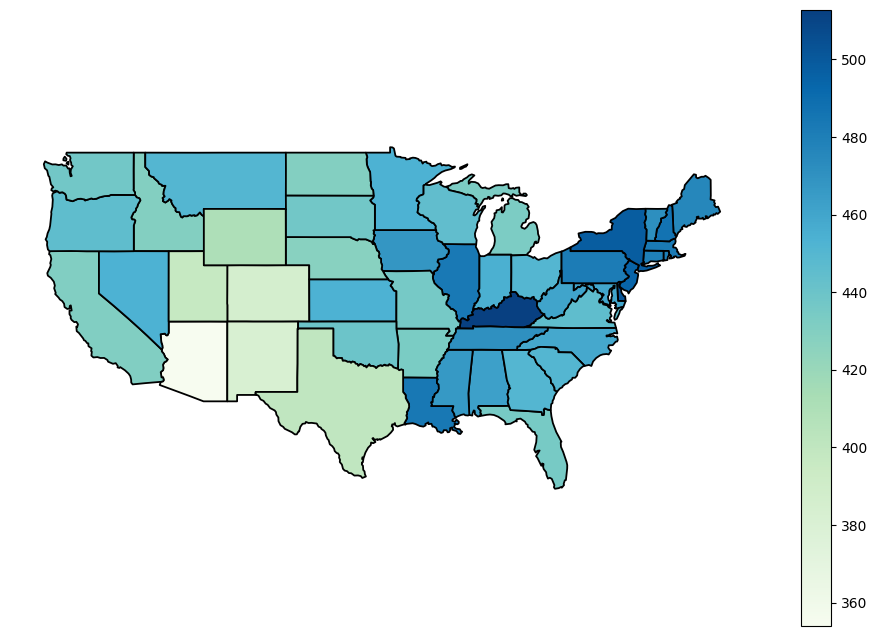

In [96]:
pipeUSA(colMean, "incidencerate", "agg_col_mean",
        savepath="../outputs/USA/USA_incidencerate.png")


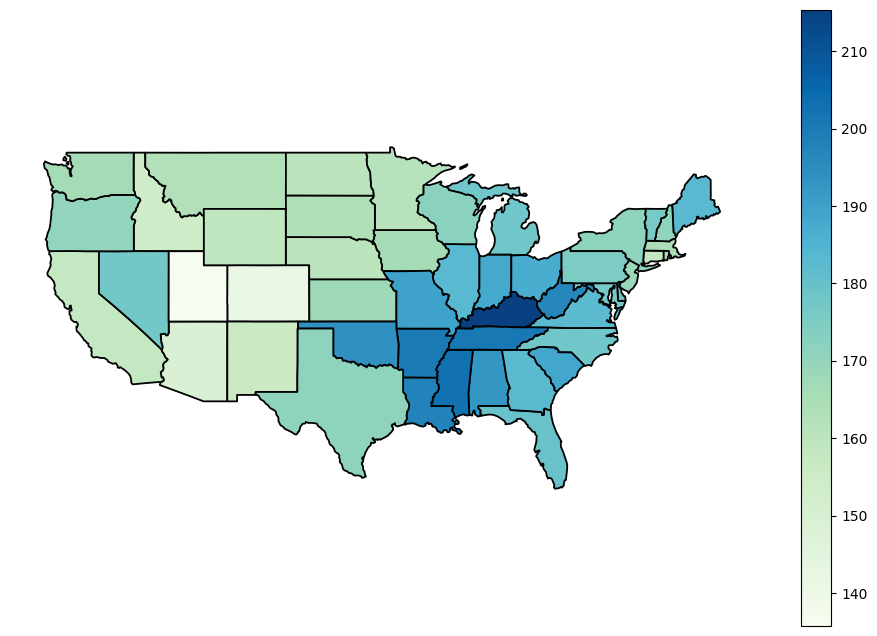

In [97]:
pipeUSA(colMean, "target_deathrate", "agg_col_mean",
        savepath="../outputs/USA/USA_target_deathrate.png")


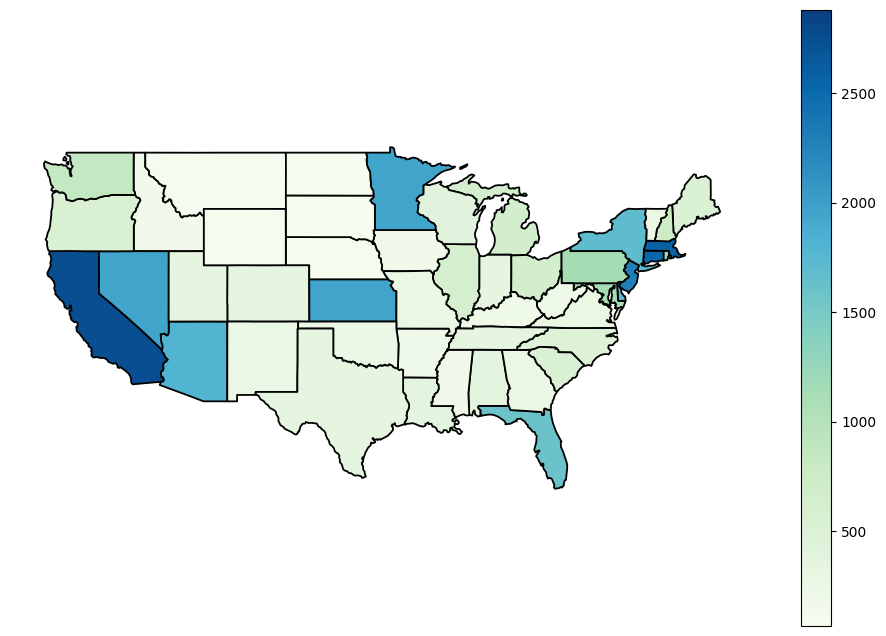

In [98]:
pipeUSA(colMean, "avganncount", "agg_col_mean",
        savepath="../outputs/USA/USA_avganncount.png")


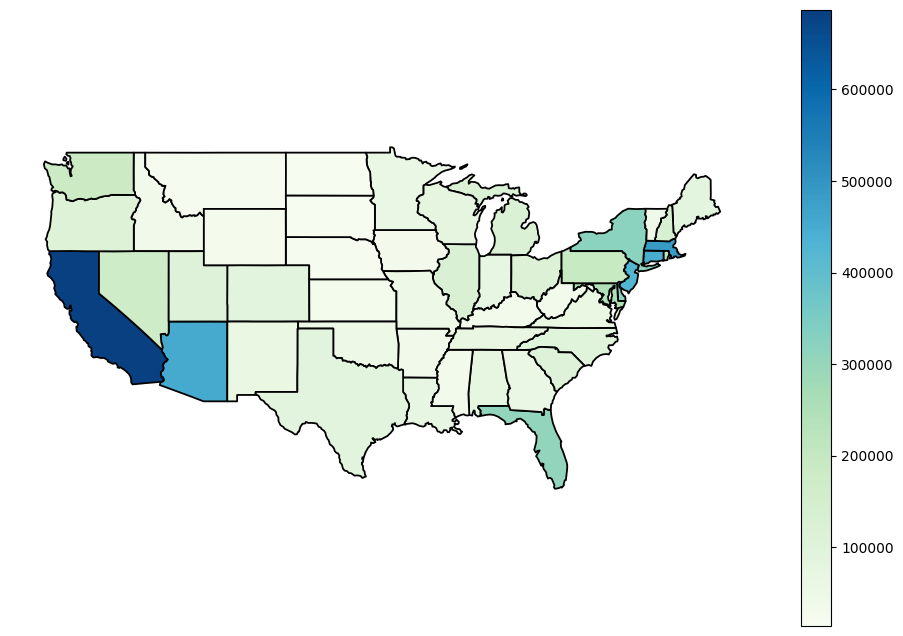

In [99]:
pipeUSA(colMean, "popest2015", "agg_col_mean",
        savepath="../outputs/USA/USA_popest2015.png")


In [100]:
df = pd.read_csv("../data/where/USA.csv")
df["popest2015"].max()

np.int64(10170292)